In [1]:
import math, os
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import matplotlib.pyplot as plt
from d2l import tensorflow as d2l


# Start
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
train_random_iter, vocab_random_iter = d2l.load_data_time_machine(batch_size, num_steps, use_random_iter=True)
tf.one_hot(tf.constant([0, 2]), len(vocab))

<tf.Tensor: shape=(2, 28), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [4]:
X = tf.reshape(tf.range(10), (2, 5))
tf.one_hot(tf.transpose(X), 28)

<tf.Tensor: shape=(5, 2, 28), dtype=float32, numpy=
array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 

In [5]:
tf.one_hot(tf.transpose(X), 28).shape

TensorShape([5, 2, 28])

In [6]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32)

    # Hidden layer parameters
    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
    # Output layer parameters
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

def init_rnn_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)), )

def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        X = tf.reshape(X,[-1,W_xh.shape[0]])
        H = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(H, W_hh) + b_h)
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,)

class RNNModelScratch: #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state, params):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        return self.forward_fn(X, state, params)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

In [7]:
# defining tensorflow training strategy
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
num_hiddens = 512

with strategy.scope():
    net = RNNModelScratch(len(vocab), num_hiddens, init_rnn_state, rnn)
state = net.begin_state(X.shape[0])
params = get_params(len(vocab), num_hiddens)
Y, new_state = net(X, state, params)
Y.shape, len(new_state), new_state[0].shape

(TensorShape([10, 28]), 1, TensorShape([2, 512]))

In [8]:
def predict_ch8(prefix, num_preds, net, vocab, params):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: tf.reshape(tf.constant([outputs[-1]]), (1, 1)).numpy()
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state, params)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state, params)
        outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab, params)

'time traveller fvcgnooooo'

In [9]:
def grad_clipping(grads, theta): #@save
    """Clip the gradient."""
    theta = tf.constant(theta, dtype=tf.float32)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in grads))
    norm = tf.cast(norm, tf.float32)
    new_grad = []
    if tf.greater(norm, theta):
        for grad in grads:
            new_grad.append(grad * theta / norm)
    else:
        for grad in grads:
            new_grad.append(grad)
    return new_grad

#@save
def train_epoch_ch8(net, train_iter, loss, updater, params, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0])
        with tf.GradientTape(persistent=True) as g:
            g.watch(params)
            y_hat, state= net(X, state, params)
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        grads = g.gradient(l, params)
        grads = grad_clipping(grads, 1)
        updater.apply_gradients(zip(grads, params))

        # Keras loss by default returns the average loss in a batch
        # l_sum = l * float(tf.size(y).numpy()) if isinstance(
        #     loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l * tf.size(y).numpy(), tf.size(y).numpy())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

#@save
def train_ch8(net, train_iter, vocab, num_hiddens, lr, num_epochs, strategy,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    with strategy.scope():
        params = get_params(len(vocab), num_hiddens)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, params)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
             net, train_iter, loss, updater, params, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.0, 21698.9 tokens/sec on /GPU:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


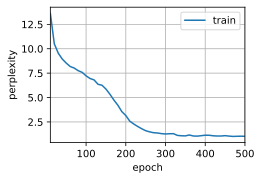

In [10]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, num_hiddens, lr, num_epochs, strategy)

In [ ]:
params = get_params(len(vocab_random_iter), num_hiddens)
train_ch8(net, train_random_iter, vocab_random_iter, num_hiddens, lr, num_epochs, strategy, use_random_iter=True)
plt.show()

perplexity 1.5, 21933.3 tokens/sec on /GPU:0
time traveller but now you begin to seethe object of my investig
traveller after the pauserequired for the proper assimilati


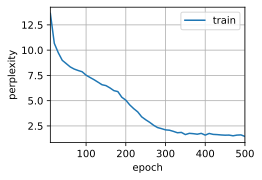